<a href="https://colab.research.google.com/github/AnkitaSavaliya/AIH/blob/main/MIMIC-IV_MORTALITY_PREDICTION_ARF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mortality Prediction for Acute Respiratory Failure Using MIMIC-IV**

In [1]:
"""
Import Libraries
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MIMIC-IV: Loading and Filter Data for Acute Respiratory Failure Analysis

In [3]:
"""
Common function to read mimic csv
"""
def read_mimic_csv_file(mimic_csv_file_name: str, low_memory: bool = False, chunksize: int = None) -> pd.DataFrame:
    """
    Read a CSV file from the MIMIC-IV dataset into a pandas DataFrame.

    Parameters:
    - mimic_csv_file_name (str): Name of the CSV file.
    - low_memory (bool): Whether to use low memory mode when reading.
    - chunksize (int, optional): Number of rows per chunk if reading in chunks.

    Returns:
    - pd.DataFrame
    """
    # Define the root directory of MIMIC-IV data in Google Drive
    mimic_root_dir_path = "/content/drive/MyDrive/Colab Notebooks/AIH/MIMIC-IV/"
    file_path = mimic_root_dir_path + mimic_csv_file_name

    return pd.read_csv(file_path, low_memory=low_memory, chunksize=chunksize)

In [4]:
"""
 Read, filter, and merge MIMIC-IV data for acute respiratory failure patients.
"""

# Load diagnoses data
arf_diagnoses_df = read_mimic_csv_file("diagnoses_icd.csv.gz")

# Define relevant ICD-9 and ICD-10 codes for acute respiratory failure(MIMIC-IV contains both ICD-9 and ICD-10 codes)
arf_icd_codes = {'51851', '51881', 'J960', 'J9600', 'J9601', 'J9602'}

# Filter diagnoses dataset
arf_diagnoses_df = arf_diagnoses_df[arf_diagnoses_df['icd_code'].isin(arf_icd_codes)].copy()

# Drop unnecessary columns
arf_diagnoses_df.drop(columns=['seq_num', 'icd_code', 'icd_version'], inplace=True, errors='ignore')

# Remove duplicates
arf_diagnoses_df.drop_duplicates(inplace=True)

# Merge with admissions data
arf_admissions_df = read_mimic_csv_file('admissions.csv.gz')

arf_merged_df = arf_diagnoses_df.merge(
    arf_admissions_df, on=['subject_id', 'hadm_id'], how='inner'
)

arf_merged_df.drop(columns=['dischtime', 'deathtime', 'admit_provider_id', 'discharge_location',
                            'language', 'edregtime', 'edouttime'], inplace=True, errors='ignore')

arf_merged_df.drop_duplicates(inplace=True)
arf_merged_df.reset_index(drop=True, inplace=True)

# Merge with patient demographics
arf_patients_df = read_mimic_csv_file('patients.csv.gz')

arf_merged_df = arf_merged_df.merge(
    arf_patients_df, on=['subject_id'], how='inner'
)

arf_merged_df.drop(columns=['dod', 'anchor_year_group'], inplace=True, errors='ignore')
arf_merged_df.drop_duplicates(inplace=True)
arf_merged_df.reset_index(drop=True, inplace=True)

# Merge with ICU stays
arf_icustays_df = read_mimic_csv_file('icustays.csv.gz')

arf_merged_df = arf_merged_df.merge(
    arf_icustays_df, on=['subject_id', 'hadm_id'], how='inner'
)

arf_merged_df.drop(columns=['last_careunit', 'intime', 'outtime', 'los', 'stay_id'], inplace=True, errors='ignore')
arf_merged_df.drop_duplicates(inplace=True)
arf_merged_df.reset_index(drop=True, inplace=True)

# Define lab test keywords related to respiratory function
resp_lab_tests = {
    'oxygen saturation', 'oxygen', 'ph', 'pco2',
    'bicarbonate', 'lactate', 'calculated bicarbonate, whole blood'
}

# Load lab item details
lab_items_df = read_mimic_csv_file('d_labitems.csv.gz')

# Filter respiratory-related blood lab items
lab_items_df = lab_items_df[
    (lab_items_df['fluid'] == 'Blood') &
    (lab_items_df['label'].str.lower().str.strip().isin(resp_lab_tests))
].copy()

# Drop unnecessary columns
lab_items_df.drop(columns=['fluid', 'category'], inplace=True, errors='ignore')
lab_items_df.drop_duplicates(inplace=True)
lab_items_df.reset_index(drop=True, inplace=True)

# Extract unique subject_id and hadm_id pairs
subject_hadm_set = arf_merged_df[['subject_id', 'hadm_id']].drop_duplicates().reset_index(drop=True)

# Process lab events data in chunks to manage memory efficiently
lab_chunks = []
for lab_chunk in read_mimic_csv_file('labevents.csv.gz', low_memory=False, chunksize=10**7):
    # Drop irrelevant columns
    lab_chunk.drop(columns=['labevent_id', 'value', 'valueuom', 'flag', 'ref_range_lower', 'ref_range_upper',
                            'priority', 'specimen_id', 'order_provider_id', 'storetime', 'comments'],
                   inplace=True, errors='ignore')

    # Merge with filtered lab items
    lab_chunk = lab_chunk.merge(lab_items_df, on='itemid', how='inner')
    lab_chunk.drop(columns=['itemid'], inplace=True, errors='ignore')

    # Keep only data for acute respiratory failure patients
    lab_chunk = lab_chunk.merge(subject_hadm_set, on=['subject_id', 'hadm_id'], how='inner')

    # Sort for time-based aggregation
    lab_chunk.sort_values(by=['subject_id', 'hadm_id', 'charttime'], inplace=True)

    # Aggregate lab test values by median per subject_id, hadm_id, and label
    lab_chunk = lab_chunk.groupby(['subject_id', 'hadm_id', 'label'], as_index=False)['valuenum'].median()

    lab_chunks.append(lab_chunk)

# Merge processed lab event data with the main dataset
if lab_chunks:
    arf_merged_df = arf_merged_df.merge(pd.concat(lab_chunks, ignore_index=True),
                                        on=['subject_id', 'hadm_id'], how='inner')

# Remove duplicate rows
arf_merged_df.drop_duplicates(subset=['subject_id', 'hadm_id', 'label'], inplace=True)
arf_merged_df.reset_index(drop=True, inplace=True)

In [5]:
# Display dataset info
arf_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83237 entries, 0 to 83236
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            83237 non-null  int64  
 1   hadm_id               83237 non-null  int64  
 2   admittime             83237 non-null  object 
 3   admission_type        83237 non-null  object 
 4   admission_location    83237 non-null  object 
 5   insurance             81768 non-null  object 
 6   marital_status        72965 non-null  object 
 7   race                  83237 non-null  object 
 8   hospital_expire_flag  83237 non-null  int64  
 9   gender                83237 non-null  object 
 10  anchor_age            83237 non-null  int64  
 11  anchor_year           83237 non-null  int64  
 12  first_careunit        83237 non-null  object 
 13  label                 83237 non-null  object 
 14  valuenum              83213 non-null  float64
dtypes: float64(1), int6

In [6]:
arf_merged_df.head()

,subject_id,hadm_id,admittime,admission_type,admission_location,insurance,marital_status,race,hospital_expire_flag,gender,anchor_age,anchor_year,first_careunit,label,valuenum
0,10000690,25860671,2150-11-02 18:02:00,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,86,2150,Medical Intensive Care Unit (MICU),Bicarbonate,34.00
1,10000690,25860671,2150-11-02 18:02:00,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,86,2150,Medical Intensive Care Unit (MICU),pCO2,52.00
2,10000690,25860671,2150-11-02 18:02:00,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,86,2150,Medical Intensive Care Unit (MICU),pH,7.45
3,10001843,26133978,2134-12-05 00:10:00,URGENT,TRANSFER FROM HOSPITAL,Medicare,SINGLE,WHITE,1,M,73,2131,Medical/Surgical Intensive Care Unit (MICU/SICU),Bicarbonate,28.50
4,10001843,26133978,2134-12-05 00:10:00,URGENT,TRANSFER FROM HOSPITAL,Medicare,SINGLE,WHITE,1,M,73,2131,Medical/Surgical Intensive Care Unit (MICU/SICU),Lactate,2.40


# Preprocessing and Feature Engineering for Acute Respiratory Failure Analysis

In [7]:
# Check Missing Values
arf_merged_df.isnull().sum()

,0
subject_id,0
hadm_id,0
admittime,0
admission_type,0
admission_location,0
insurance,1469
marital_status,10272
race,0
hospital_expire_flag,0
gender,0


In [8]:
# Get unique values in the 'marital_status' column
arf_merged_df['marital_status'].unique()

array(['WIDOWED', 'SINGLE', 'MARRIED', nan, 'DIVORCED'], dtype=object)

In [9]:
# Get unique values in the 'first_careunit' column
arf_merged_df['first_careunit'].unique()

array(['Medical Intensive Care Unit (MICU)',
       'Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'Coronary Care Unit (CCU)', 'Trauma SICU (TSICU)',
       'Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'Surgical Intensive Care Unit (SICU)', 'Neuro Intermediate',
       'Cardiac Vascular Intensive Care Unit (CVICU)', 'Neuro Stepdown',
       'Intensive Care Unit (ICU)', 'Surgery/Vascular/Intermediate',
       'PACU', 'Medicine', 'Surgery/Trauma', 'Med/Surg'], dtype=object)

In [10]:
# Get unique values in the 'race' column
arf_merged_df['race'].unique()

array(['WHITE', 'BLACK/AFRICAN AMERICAN', 'UNKNOWN', 'PORTUGUESE',
       'BLACK/CAPE VERDEAN', 'ASIAN - SOUTH EAST ASIAN',
       'WHITE - OTHER EUROPEAN', 'WHITE - BRAZILIAN', 'UNABLE TO OBTAIN',
       'HISPANIC/LATINO - CUBAN', 'HISPANIC OR LATINO',
       'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - PUERTO RICAN',
       'ASIAN - CHINESE', 'OTHER',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
       'HISPANIC/LATINO - SALVADORAN', 'BLACK/CARIBBEAN ISLAND', 'ASIAN',
       'ASIAN - ASIAN INDIAN', 'HISPANIC/LATINO - HONDURAN',
       'HISPANIC/LATINO - COLUMBIAN', 'WHITE - RUSSIAN',
       'PATIENT DECLINED TO ANSWER', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - CENTRAL AMERICAN', 'ASIAN - KOREAN',
       'SOUTH AMERICAN', 'WHITE - EASTERN EUROPEAN',
       'AMERICAN INDIAN/ALASKA NATIVE', 'HISPANIC/LATINO - GUATEMALAN',
       'HISPANIC/LATINO - MEXICAN', 'MULTIPLE RACE/ETHNICITY'],
      dtype=object)

In [11]:
# Get statistical summary of 'anchor_age' to understand its distribution for appropriate grouping
arf_merged_df['anchor_age'].describe()

,anchor_age
count,83237.000000
mean,64.066869
std,16.117273
min,18.000000
25%,54.000000
50%,65.000000
75%,76.000000
max,91.000000


In [12]:
import itertools

"""
 Preprocessing and Feature Engineering for required features
"""

# Create a copy of the merged Acute Respiratory Failure dataset for processing
arf_processed_df = arf_merged_df.copy()

# Map Gender Column
arf_processed_df['gender'] = arf_processed_df['gender'].map({'F': 'Female', 'M': 'Male'})

# Handle missing values in marital status by replacing NaNs with 'Unknown'
arf_processed_df['marital_status'] = arf_processed_df['marital_status'].fillna('Unknown')

# Handle missing values in insurance by replacing NaNs with 'Unknown'
arf_processed_df['insurance'] = arf_processed_df['insurance'].fillna('Unknown')

# Convert admission time to datetime format
arf_processed_df['admittime'] = pd.to_datetime(arf_processed_df['admittime'])

# Compute patient age at admission using MIMIC-IV anchor values
arf_processed_df['admission_age'] = (
    arf_processed_df['anchor_age'] +
    (arf_processed_df['admittime'].dt.year - arf_processed_df['anchor_year'])
)

# Categorize patients into age groups: Young (<30), Adult (30-60), Senior (60+)
arf_processed_df['age_group'] = pd.cut(
    arf_processed_df['admission_age'],
    bins=[0, 30, 60, float('inf')],
    labels=['Young', 'Adult', 'Senior'],
    right=False
)

# Remove unnecessary columns after computing age group
arf_processed_df.drop(columns=['admittime', 'anchor_year', 'anchor_age', 'admission_age'], inplace=True)

# Convert age group to string type
arf_processed_df['age_group'] = arf_processed_df['age_group'].astype(str)

# Standardize race categories by grouping similar values
arf_processed_df['race'] = arf_processed_df['race'].replace(
    {r"ASIAN\D*": "ASIAN",
     r"WHITE\D*": "WHITE",
     r"HISPANIC\D*": "HISPANIC/LATINO",
     r"BLACK\D*": "BLACK/AFRICAN AMERICAN"},
    regex=True
)

# Replace ambiguous race values with 'OTHER/UNKNOWN'
arf_processed_df['race'] = arf_processed_df['race'].replace(
    ['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN', 'MULTIPLE RACE/ETHNICITY'],
    'OTHER/UNKNOWN'
)

# Standardize ICU (first care unit) categories by grouping related units
arf_processed_df['first_careunit'] = arf_processed_df['first_careunit'].replace(
    {r"Medical/Surgical\D*": "MICU, SICU",
     r"Medical\D*": "MICU",
     r"Neuro\D*": "NSICU",
     r"Cardiac\D*": "CVICU",
     r"Coronary\D*": "CCU",
     r"Trauma SICU\D*": "TSICU",
     r"Surgical\D*": "SICU",
     r"Intensive Care Unit\D*": "ICU"},
    regex=True
)

# Convert uncommon ICU categories into 'OTHERICU'
arf_processed_df['first_careunit'] = arf_processed_df['first_careunit'].replace(
    ['Surgery/Vascular/Intermediate', 'PACU', 'Medicine', 'Surgery/Trauma', 'Med/Surg', 'Neuro Stepdown'],
    'OTHER_ICU'
)

# Convert ICU categories into separate binary columns (one-hot encoding)
arf_processed_df['first_careunit'] = arf_processed_df['first_careunit'].str.split(', ', expand=False).reset_index(drop=True)
arf_processed_df = arf_processed_df.join(
    pd.get_dummies(arf_processed_df['first_careunit'].apply(pd.Series).stack(), dtype=int)
    .groupby(level=0)
    .sum(),
    how='outer'
)

# Remove the original ICU category column after encoding
arf_processed_df.drop(columns=['first_careunit'], inplace=True)

# Aggregate lab test results by subject_id and hadm_id
tmp = arf_processed_df.groupby(['subject_id', 'hadm_id'], as_index=False)[['label', 'valuenum']].agg(list).reset_index(drop=True)

# Drop old lab event columns since they have been aggregated
arf_processed_df.drop(columns=['label', 'valuenum'], inplace=True)

# Merge aggregated lab results back into the main dataframe
arf_processed_df = arf_processed_df.merge(tmp, on=['subject_id', 'hadm_id'], how='inner')

# Clean up temporary variable
del tmp

# Extract unique lab test names from the 'label' column
all_labels = sorted(set(itertools.chain.from_iterable(arf_processed_df['label'])))

# Expand 'valuenum' into separate columns with lab test names as headers
arf_processed_df = arf_processed_df.join(
    pd.DataFrame(arf_processed_df['valuenum'].to_list(), columns=all_labels),
    how="outer"
)

# Drop unnecessary columns after transformation
arf_processed_df.drop(columns=['subject_id', 'hadm_id', 'label', 'valuenum'], inplace=True, errors='ignore')

# Handle missing values by replacing NaNs with 0
arf_processed_df.fillna(0, inplace=True)

# One-hot encode category columns: admission type, insurance, race, gender, admission location, and marital status
prefix_cols = ['age', "admission_type", "insurance", 'race', 'gender', 'loc', 'marital_status']
dummy_cols = ['age_group', 'admission_type', 'insurance', 'race', 'gender', 'admission_location', 'marital_status']
arf_processed_df = pd.get_dummies(arf_processed_df, prefix=prefix_cols, columns=dummy_cols, dtype=int)

# Drop duplicates, drop rows with NaN, and reset indices
arf_processed_df.drop_duplicates(inplace=True)
arf_processed_df.dropna(inplace=True)
arf_processed_df.reset_index(drop=True, inplace=True)

arf_processed_df.head()

,hospital_expire_flag,CCU,CVICU,ICU,MICU,NSICU,OTHER_ICU,SICU,TSICU,Bicarbonate,...,loc_PHYSICIAN REFERRAL,loc_PROCEDURE SITE,loc_TRANSFER FROM HOSPITAL,loc_TRANSFER FROM SKILLED NURSING FACILITY,loc_WALK-IN/SELF REFERRAL,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_Unknown,marital_status_WIDOWED
0,0,0,0,0,1,0,0,0,0,34.0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,1,0,28.5,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,0,1,0,0,0,0,33.0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,27.0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,1,0,24.0,...,0,0,0,0,0,0,1,0,0,0


In [13]:
# Exploring the columns of preprocessed data
processed_data = arf_processed_df.copy()
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17003 entries, 0 to 17002
Data columns (total 60 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   hospital_expire_flag                            17003 non-null  int64  
 1   CCU                                             17003 non-null  int64  
 2   CVICU                                           17003 non-null  int64  
 3   ICU                                             17003 non-null  int64  
 4   MICU                                            17003 non-null  int64  
 5   NSICU                                           17003 non-null  int64  
 6   OTHER_ICU                                       17003 non-null  int64  
 7   SICU                                            17003 non-null  int64  
 8   TSICU                                           17003 non-null  int64  
 9   Bicarbonate                            

# Splitting the Data into Training and Test Sets

In [14]:
# Check the distribution of hospital mortality outcomes
processed_data['hospital_expire_flag'].value_counts()

,count
hospital_expire_flag,
0,12424
1,4579


In [15]:
# Create a copy of the processed data
df = processed_data.copy()
print("Original dataset size:", len(df))
print(df['hospital_expire_flag'].value_counts())

# Define features (X) and target (y)
X = df.drop(columns=['hospital_expire_flag'])  # Features
y = df['hospital_expire_flag']  # Target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("\nTraining set size:", len(X_train))
print("Test set size:", len(X_test) ,"\n")

print('-------------------------')
# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Training set size after SMOTE:", len(X_train_resampled), "\n")

# Check class distribution after SMOTE
print(pd.Series(y_train_resampled).value_counts())

Original dataset size: 17003
hospital_expire_flag
0    12424
1     4579
Name: count, dtype: int64

Training set size: 13602
Test set size: 3401 

-------------------------
Training set size after SMOTE: 19878 

hospital_expire_flag
1    9939
0    9939
Name: count, dtype: int64


# Model Evaluation and Comparison

In [16]:
"""
    Common function to prints model's performance metrics.
"""
def print_model_performance_metrics(name, accuracy, auc_roc, precision, recall, f1, classification_report_output, confusion_matrix_output):
    """
    Prints model's performance metrics.

    Parameters:
    name (str): Name of the model.
    accuracy (float): Accuracy of the model.
    auc_roc (float): AUC-ROC of the model.
    precision (float): Precision of the model.
    recall (float): Recall of the model.
    f1 (float): F1-Score of the model.
    classification_report_output (str): Classification report of the model.
    confusion_matrix_output (ndarray): Confusion matrix of the model.
    """
    # Print performance metrics
    print(f"\n{name} Performance:")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" AUC-ROC: {auc_roc:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1-Score: {f1:.4f}")

    # Print the classification report
    print("Classification Report:")
    print(classification_report_output)

    # Print the confusion matrix
    print(f"Confusion Matrix for {name}:\n {confusion_matrix_output}")

##  Evaluate Classification Models

In [17]:
"""
 Evaluate Classification Models
"""
warnings.filterwarnings('ignore')

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Initialize Models
models = {
    "Logistic Regression": LogisticRegression(random_state=0),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(learning_rate=0.1, objective='binary:logistic', random_state=0, eval_metric='mlogloss')
}

# Prepare lists to store metrics
metrics = []

# Train and evaluate models on balanced data
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    # Evaluate Model
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append metrics for comparison
    metrics.append([accuracy, auc_roc, precision, recall, f1])

    # Print Model Performance Metrics
    cf = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print_model_performance_metrics(name, accuracy, auc_roc, precision, recall, f1, cf , cm)

# Create a DataFrame for model performance comparison
metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score'], index=models.keys())
print("\nModel Performance Comparison:")
display(metrics_df)


Logistic Regression Performance:
 Accuracy: 0.7754
 AUC-ROC: 0.7702
 Precision: 0.6590
 Recall: 0.3439
 F1-Score: 0.4519
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      2485
           1       0.66      0.34      0.45       916

    accuracy                           0.78      3401
   macro avg       0.73      0.64      0.66      3401
weighted avg       0.76      0.78      0.75      3401

Confusion Matrix for Logistic Regression:
 [[2322  163]
 [ 601  315]]

Decision Tree Performance:
 Accuracy: 0.6998
 AUC-ROC: 0.6233
 Precision: 0.4443
 Recall: 0.4574
 F1-Score: 0.4508
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      2485
           1       0.44      0.46      0.45       916

    accuracy                           0.70      3401
   macro avg       0.62      0.62      0.62      3401
weighted avg       0.70      0.70      0.70    

,Accuracy,AUC-ROC,Precision,Recall,F1-Score
Logistic Regression,0.775360,0.770217,0.658996,0.343886,0.451937
Decision Tree,0.699794,0.623279,0.444327,0.457424,0.450780
Random Forest,0.794472,0.782850,0.695495,0.421397,0.524813
Gradient Boosting,0.797413,0.794970,0.698774,0.435590,0.536651
XGBoost,0.807704,0.811770,0.748106,0.431223,0.547091


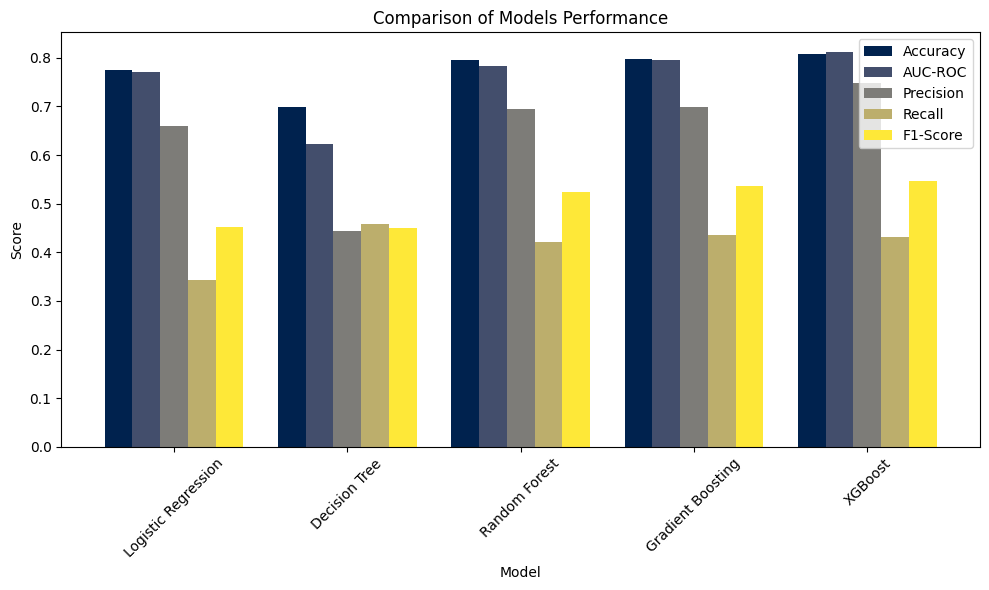

In [18]:
"""
Common function to plot model performance metrics comparison
"""
def plot_model_metrics_comparison(metrics):
  # Plot comparison of models in a single bar plot
  metrics.plot(kind='bar', figsize=(10, 6), colormap='cividis', width=0.8)
  plt.title('Comparison of Models Performance')
  plt.ylabel('Score')
  plt.xlabel('Model')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

plot_model_metrics_comparison(metrics_df)

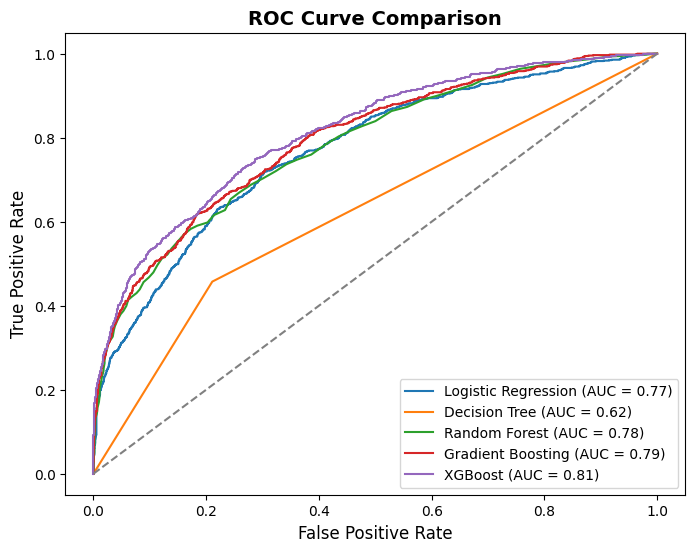

In [19]:
"""
Plot ROC Curve comparision for all models
"""
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(8, 6))

# Plot ROC curve for each model
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")

# Plot the diagonal line representing random classifier performance
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Add labels and title
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve Comparison", fontsize=14, fontweight='bold')

# Show the legend
plt.legend(loc="lower right")

# Show the plot
plt.show()

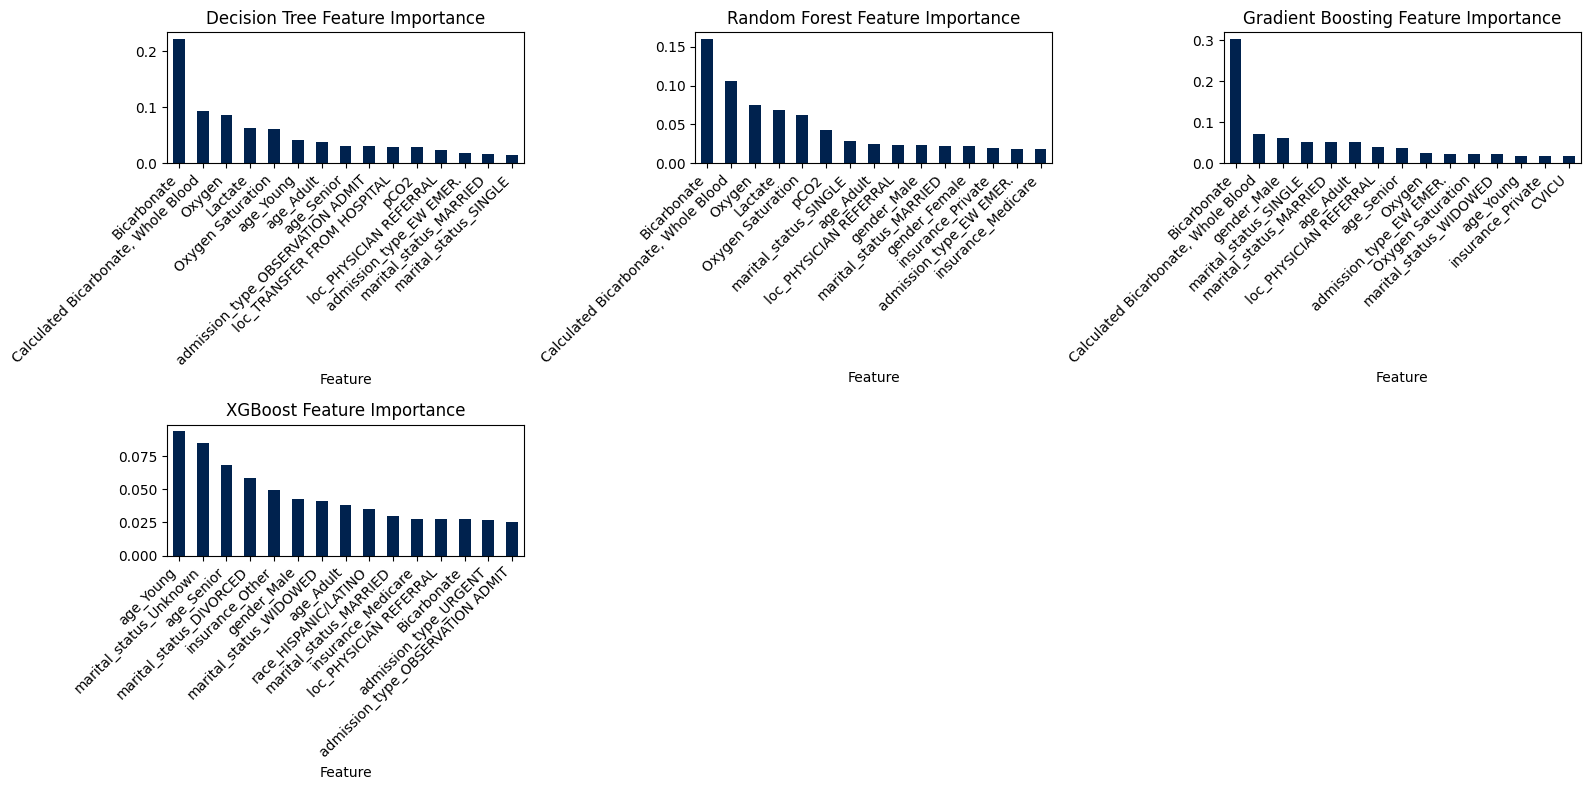

In [20]:
import math

"""
Plotting Feature Importance for Model Comparison
"""

# Function to plot feature importance for each model
def plot_feature_importance(models, X_train, feature_names):
    # Dynamically calculate number of rows and columns based on the number of models with feature importances
    valid_models = {name: model for name, model in models.items() if hasattr(model, 'feature_importances_') or hasattr(model, 'get_feature_importance')}
    num_models = len(valid_models)

    if num_models == 0:
        print("No models with feature importance found.")
        return

    rows = math.ceil(num_models / 3)  # 3 columns per row
    cols = min(3, num_models)  # Ensure we have at most 3 columns per row

    plt.figure(figsize=(16, 4 * rows))  # Adjust height based on rows

    # Iterate over models to plot feature importance
    for idx, (name, model) in enumerate(valid_models.items()):
        # For models that have feature importances
        if hasattr(model, 'feature_importances_'):
            feature_importance = model.feature_importances_
        elif hasattr(model, 'get_feature_importance'):  # For models like CatBoost
            feature_importance = model.get_feature_importance()

        # Create a DataFrame for feature importances and sort it
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        })

        # Plot top important features
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)

        # Define position in the grid for subplots (idx + 1 will handle 1-based indexing in subplot)
        ax = plt.subplot(rows, cols, idx + 1)

        # Plot feature importance for the current model
        feature_importance_df.plot.bar(x='Feature', y='Importance', legend=False, title=f"{name} Feature Importance", ax=ax, colormap='cividis')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Assuming X_train_resampled and models are defined
feature_names = X_train.columns
plot_feature_importance(models, X_train_resampled, feature_names)

In [21]:
"""
Tune best model XGBoost
"""

# Define hyperparameters to tune for XGBClassifier
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

# Initialize model
xgb = XGBClassifier(learning_rate=0.1, objective='binary:logistic', random_state=0, eval_metric='mlogloss')

# Grid Search with 5-Fold Cross Validation
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters & best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best AUC-ROC Score: {grid_search.best_score_:.4f}")

# Evaluate on test data
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Evaluate the best XGBoost model
accuracy = accuracy_score(y_test, y_pred_best)
auc_roc = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

# Append metrics for comparison
new_row = pd.Series([accuracy, auc_roc, precision, recall, f1],
                    index=metrics_df.columns, name="Tuned XGBoost")
# Use pd.concat to add the new row to the DataFrame
metrics_df = pd.concat([metrics_df, new_row.to_frame().T])

# Print Model Performance Metrics
cf = classification_report(y_test, y_pred_best)
cm = confusion_matrix(y_test, y_pred_best)
print_model_performance_metrics('XGBoost', accuracy, auc_roc, precision, recall, f1, cf , cm)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best AUC-ROC Score: 0.8148

XGBoost Performance:
 Accuracy: 0.7236
 AUC-ROC: 0.5423
 Precision: 0.3696
 Recall: 0.0371
 F1-Score: 0.0675
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84      2485
           1       0.37      0.04      0.07       916

    accuracy                           0.72      3401
   macro avg       0.55      0.51      0.45      3401
weighted avg       0.64      0.72      0.63      3401

Confusion Matrix for XGBoost:
 [[2427   58]
 [ 882   34]]


## Evaluate Neural Network Model

In [22]:
# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Define the Deep Learning model
class ARFModel(nn.Module):
    def __init__(self, input_dim):
        super(ARFModel, self).__init__()
        self.layer11 = nn.Linear(input_dim, 128)
        self.batchnorm11 = nn.BatchNorm1d(128)
        self.layer1 = nn.Linear(128, 64)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.layer2 = nn.Linear(64, 32)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.layer3 = nn.Linear(32, 16)
        self.batchnorm3 = nn.BatchNorm1d(16)    # Batch normalization
        self.output = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.3)          # Dropout layer to reduce overfitting

    def forward(self, x):
        x = F.relu(self.batchnorm11(self.layer11(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm1(self.layer1(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm2(self.layer2(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm3(self.layer3(x)))
        x = self.dropout(x)
        x = self.output(x)
        return x

# Initialize model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
model = ARFModel(input_dim=input_dim)

# Compute class weights to handle imbalance in the dataset
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train_resampled)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Define the loss function (CrossEntropyLoss) with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training loop (200 epochs)
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Calculate various evaluation metrics
accuracy = accuracy_score(y_test_tensor, predicted)
y_prob = torch.softmax(outputs, dim=1)[:, 1]
roc_auc = roc_auc_score(y_test_tensor, y_prob)
precision = precision_score(y_test_tensor, predicted)
recall = recall_score(y_test_tensor, predicted)
f1 = f1_score(y_test_tensor, predicted)

# Append metrics for comparison
new_row = pd.Series([accuracy, auc_roc, precision, recall, f1],
                    index=metrics_df.columns, name='Neural Network')
# Use pd.concat to add the new row to the DataFrame
metrics_df = pd.concat([metrics_df, new_row.to_frame().T])

# Print Model Performance Metrics
cf = classification_report(y_test_tensor, predicted)
cm = confusion_matrix(y_test_tensor, predicted)
print_model_performance_metrics('Neural Network', accuracy, auc_roc, precision, recall, f1, cf , cm)

Epoch [10/200], Loss: 0.6178
Epoch [20/200], Loss: 0.5354
Epoch [30/200], Loss: 0.4801
Epoch [40/200], Loss: 0.4466
Epoch [50/200], Loss: 0.4287
Epoch [60/200], Loss: 0.4089
Epoch [70/200], Loss: 0.3967
Epoch [80/200], Loss: 0.3861
Epoch [90/200], Loss: 0.3775
Epoch [100/200], Loss: 0.3701
Epoch [110/200], Loss: 0.3606
Epoch [120/200], Loss: 0.3559
Epoch [130/200], Loss: 0.3517
Epoch [140/200], Loss: 0.3504
Epoch [150/200], Loss: 0.3465
Epoch [160/200], Loss: 0.3384
Epoch [170/200], Loss: 0.3395
Epoch [180/200], Loss: 0.3363
Epoch [190/200], Loss: 0.3371
Epoch [200/200], Loss: 0.3305

Neural Network Performance:
 Accuracy: 0.7889
 AUC-ROC: 0.5423
 Precision: 0.7271
 Recall: 0.3461
 F1-Score: 0.4689
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2485
           1       0.73      0.35      0.47       916

    accuracy                           0.79      3401
   macro avg       0.76      0.65      0.67      34

## Model Comparision

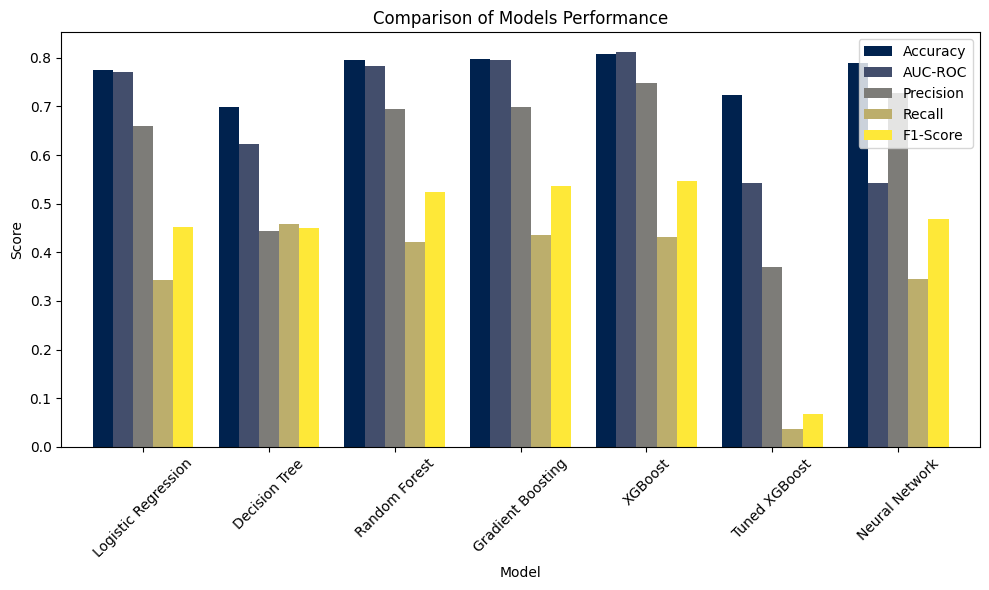

In [23]:
#Show comparision of all the models
plot_model_metrics_comparison(metrics_df)